In [30]:
import numpy as np
import pandas as pd
from scipy.special import expit, logit
import matplotlib.pyplot as plt
from scipy.ndimage import interpolation
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
class NeuralNetwork(object):
    # initialize the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        
        # set the number of nodes in each input, hidden and output layer
        self.inodes = inputnodes #784
        self.hnodes = hiddennodes #100
        self.onodes = outputnodes #10
        
        # link weight matrices wih and who
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # w12 w21
        # w22 w22 etc
        self.wih = np.random.normal(0., pow(self.hnodes, -0.5), (self.hnodes, self.inodes)) #100x784
        self.who = np.random.normal(0., pow(self.onodes, -0.5), (self.onodes, self.hnodes)) #10x100
        
        # learning rate
        self.lr = learningrate
        
        # activation function is the sigmoid function
        self.activation_function = lambda x: expit(x)
        self.inverse_activation_function = lambda x: logit(x)
    
    # train the neural network
    def train(self, inputs_list, targets_list):
        
        # convert inputs and targets lists to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs) #100x784 * 784x6000
        
        # calculate signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) #100x6000
        
        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs) #10x100 * 100x6000
        
        # calculate the signals emerging from the final output layer
        final_outputs = self.activation_function(final_inputs) #10x6000
        
        # error is the (target - actual)
        output_errors = targets - final_outputs #10x6000
        
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.who.T, output_errors) #100x10 * 10x6000 = #100x6000
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * np.dot((output_errors * final_outputs * (1. - final_outputs)), hidden_outputs.T)
        #10x6000 * 6000x100 = 10x100
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1. - hidden_outputs)), inputs.T)
        #100x6000 * 6000x784 = 100x784
    
    # query the neural network
    def query(self, inputs_list):
        
        # convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer
        hidden_inputs = np.dot(self.wih, inputs)
        
        # calculate signals emerging from hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer
        final_inputs = np.dot(self.who, hidden_outputs)
        
        # calculate the signals emerging from the final output layer
        final_outputs = self.activation_function(final_inputs)
        
        return final_outputs

In [18]:
# load the mnist training data CSV file into a list
training_data_file = open("input/train.csv", 'r')
training_data_list = training_data_file.readlines()[1:]
training_data_file.close()

In [19]:
# load the mnist test data CSV file into a list
test_data_file = open("input/test.csv", 'r')
test_data_list = test_data_file.readlines()[1:]
test_data_file.close()

In [20]:
def train_NN(neural_network, training_set, output_nodes):
    # train the neural network

    # go through all records in the training data set
    for record in training_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # scale and shift the inputs
        inputs = (np.asfarray(all_values[1:]) / 255. * .99) + .01
        # create the target output value (all 0.01 except the desired label which is 0.99)
        targets = np.zeros(output_nodes) + .01
        # all_values[0] is the target label for this record
        targets[int(all_values[0])] = .99
        n.train(inputs, targets)
        
        ## create rotated variations
        x = 10
        # rotated anticlockwise by x degrees
        inputs_plusx_img = interpolation.rotate(inputs.reshape(28,28), x, cval=0.01, order=1, reshape=False)
        n.train(inputs_plusx_img.reshape(784), targets)
        # rotated clockwise by x degrees
        inputs_minusx_img = interpolation.rotate(inputs.reshape(28,28), -x, cval=0.01, order=1, reshape=False)
        n.train(inputs_minusx_img.reshape(784), targets)

In [26]:
def test_NN(neural_network, test_set):
    # test the neural network

    # scorecard for how well the network performs, initially empty
    predictions = []

    # go through all records in the test data set
    for record in test_data_list:
        # split the record by the ',' commas
        all_values = record.split(',')
        # correct answer is first value
        # correct_label = int(all_values[0])
        # print(correct_label, "correct label")
        # scale and shift the inputs
        inputs = (np.asfarray(all_values) / 255. * .99) + .01
        # query the network
        outputs = n.query(inputs)
        # the index of the highest value corresponds to the label
        label = np.argmax(outputs)
        # print(label, "network's answer\n")
        # append correct or incorrect to the list
        predictions.append(label)
        
    return predictions

In [24]:
# Run neural network with optimized parameters on test set
input_nodes = 784
hidden_nodes = 200
output_nodes = 10
learning_rate = .01
epochs = 8

n = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

for e in range(epochs):
    print('Epoch {0}/{1}'.format(e + 1, epochs))
    train_NN(n, training_data_list, output_nodes)

Epoch 1/8
Epoch 2/8
Epoch 3/8
Epoch 4/8
Epoch 5/8
Epoch 6/8
Epoch 7/8
Epoch 8/8


ValueError: shapes (200,784) and (783,1) not aligned: 784 (dim 1) != 783 (dim 0)

In [32]:
# Make predictions on test set
predictions = test_NN(n, test_data_list)

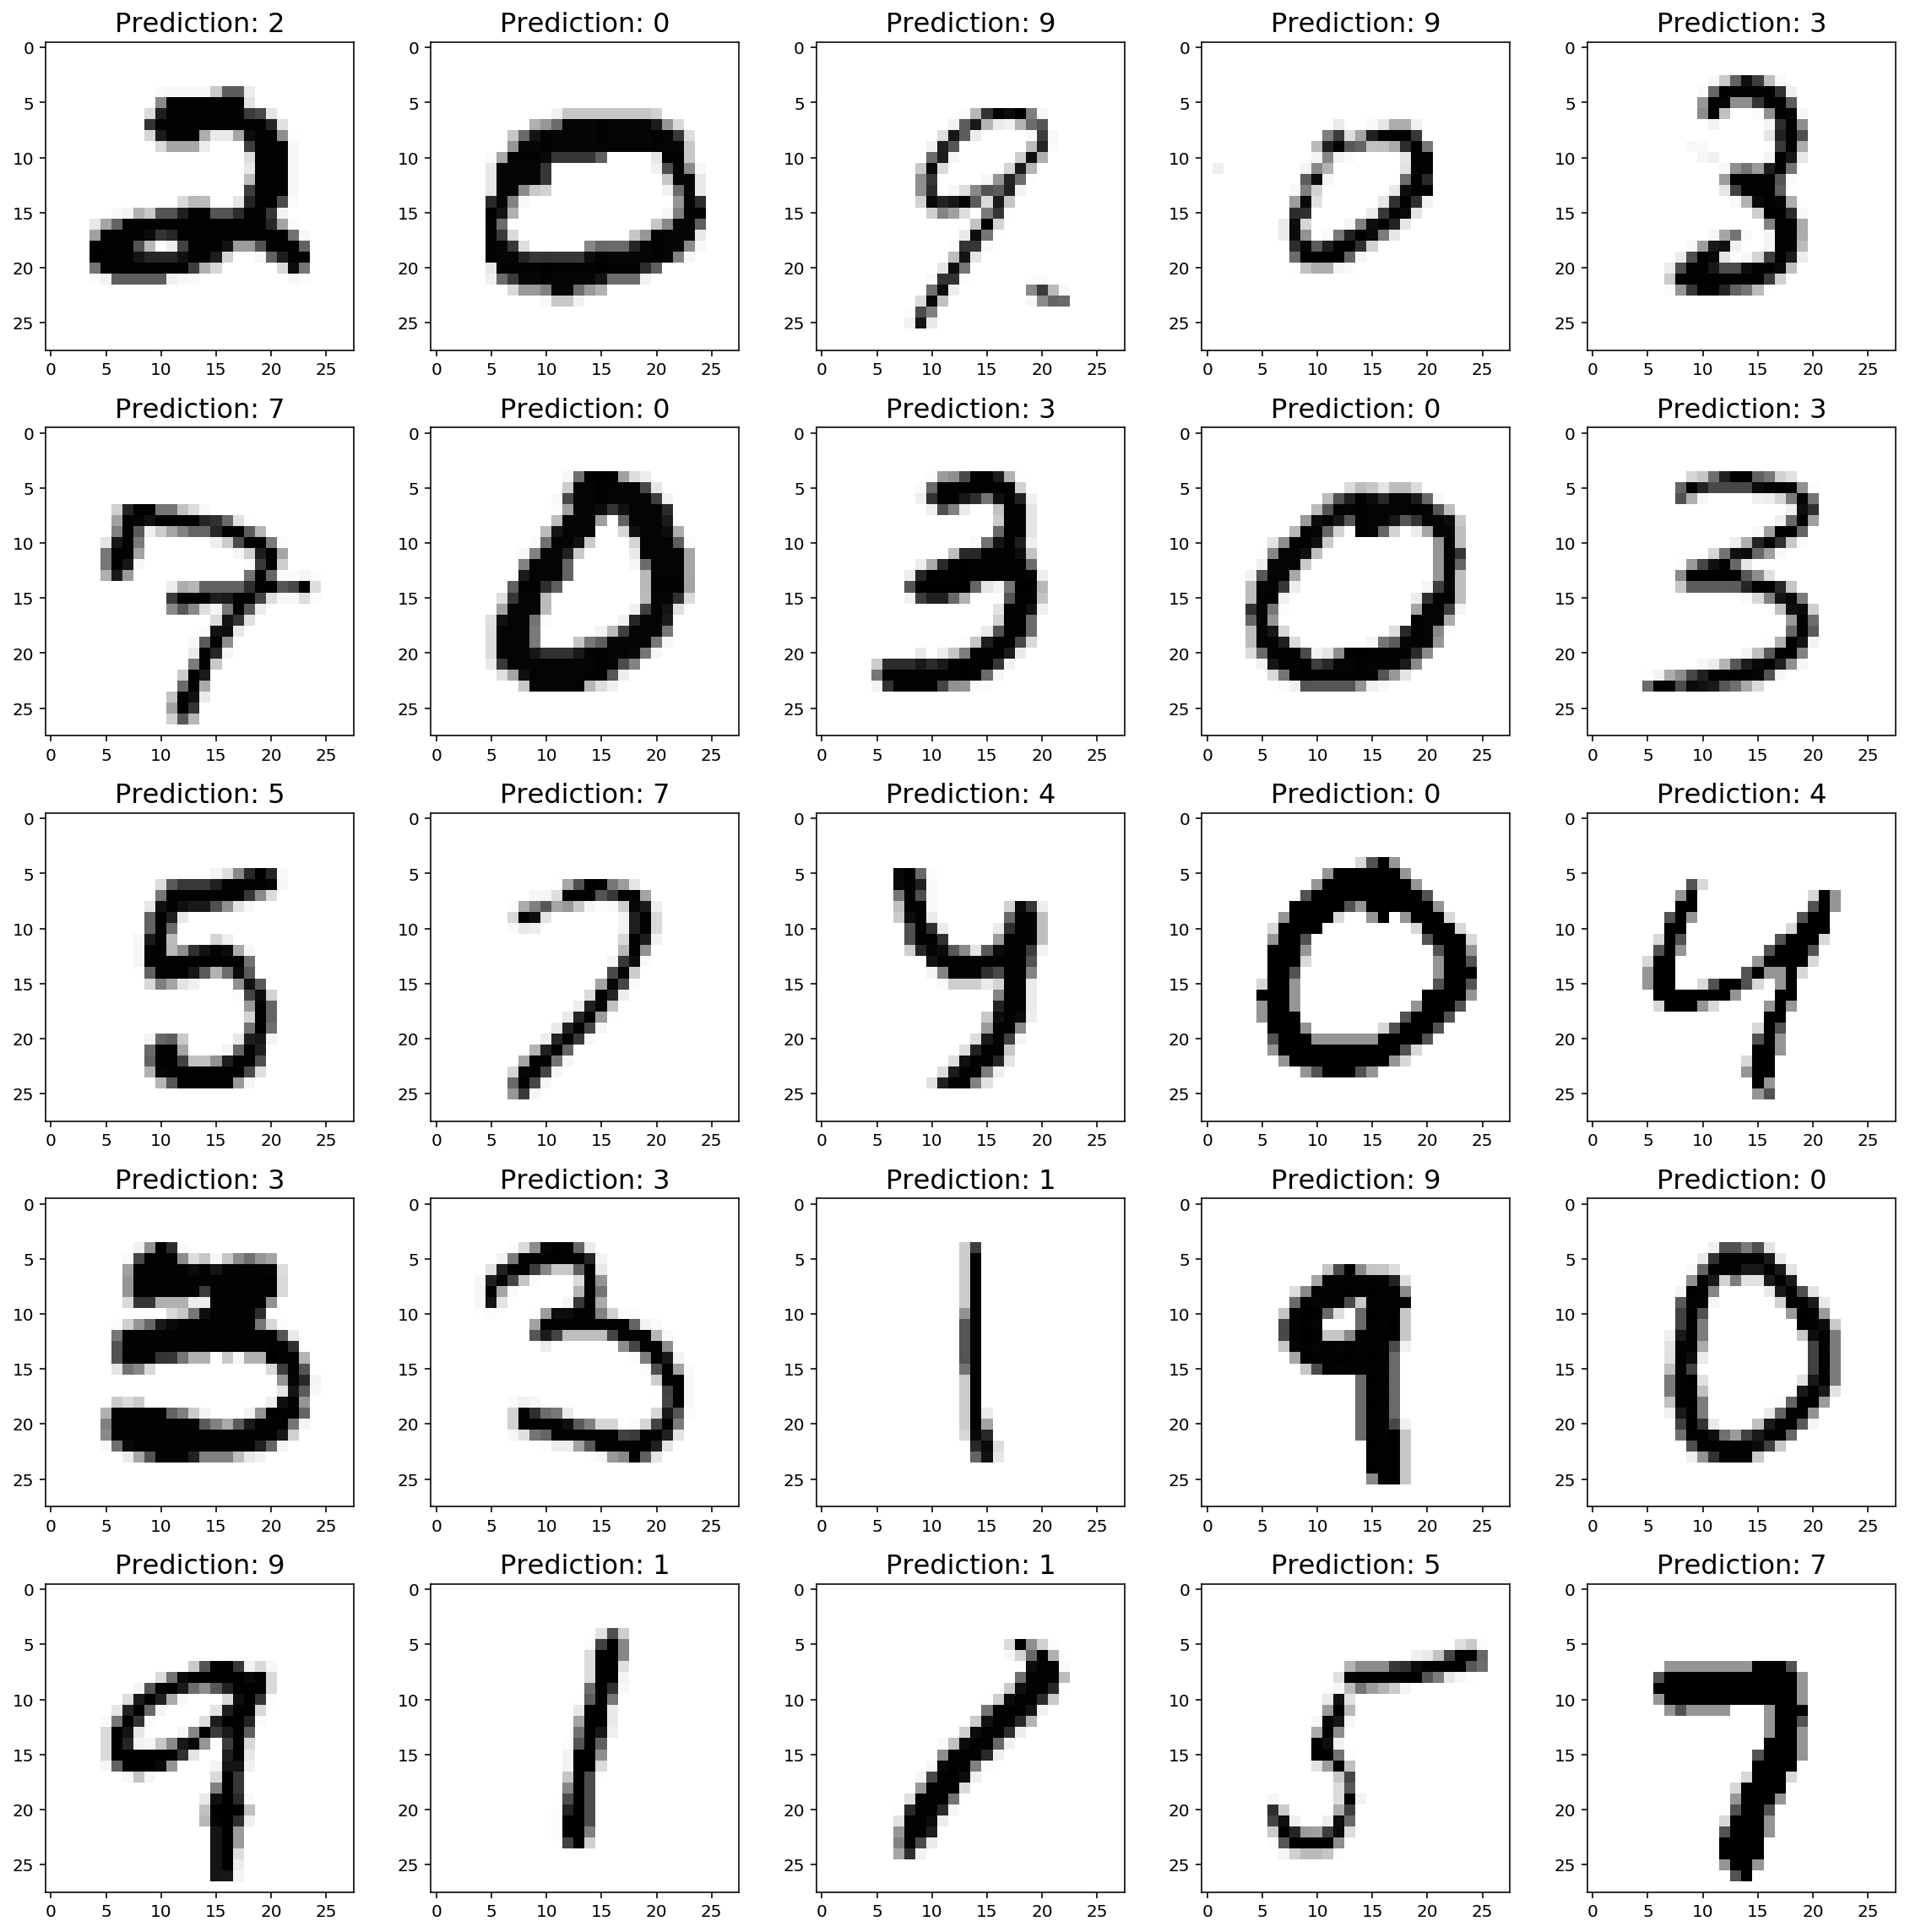

In [33]:
test_df = pd.read_csv('input/test.csv', header=0)
X_test = test_df.as_matrix()
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
for i in range(nrows*ncols):
    ax[i//ncols, i%ncols].imshow(X_test[i, :].reshape(28, 28), cmap='Greys')
    ax[i//ncols, i%ncols].set_title('Prediction: {}'.format(int(predictions[i])), fontsize=16)
plt.tight_layout()

In [34]:
pd.DataFrame({"ImageId": list(range(1, len(predictions) + 1)), 
              "Label": predictions}
            ).to_csv("submission.csv", index=False, header=True)